# Gibbs sampling for a Potts model on a 2d lattice

Ming Liang Ang.


# The math behind the model

The potts model
$$p(x) = \frac{1}{Z}\exp{-\mathcal{E}(x)}\\
\mathcal{E}(x) = - J\sum_{i\sim j}\mathbb{I}(x_i = x_j)\\
p(x_i = k | x_{-i}) = \frac{\exp(J\sum_{n\in \text{nbr}}\mathbb{I}(x_n = k))}{\sum_{k'}\exp(J\sum_{n\in \text{nbr}}\mathbb{I}(x_n = k))}$$ 

In order to efficiently compute 
$$
\sum_{n\in \text{nbr}}$$ 
for all the different states in our potts model we use a convolution. The idea is to first reperesent each potts model state as a one-hot state and then apply a convolution to compute the logits. 

$$\begin{pmatrix}
S_{11} & S_{12} & \ldots & S_{1n} \\
S_{21} & S_{22} & \ldots & S_{2n} \\
\vdots & &\ddots & \vdots\\
S_{n1} & S_{n2} & \ldots & S_{nn} \\
 \end{pmatrix} \underset{\longrightarrow}{\text{padding}} \begin{pmatrix}
 0 & \ldots & 0 & \ldots & 0 & 0\\
0 & S_{11} & S_{12} & \ldots & S_{1n} & 0 \\
0 & S_{21} & S_{22} & \ldots & S_{2n}&0 \\
\vdots & &\ddots & \vdots\\
0 & S_{n1} & S_{n2} & \ldots & S_{nn} & 0 \\
0 & \ldots & 0 & \ldots & 0 & 0\\
 \end{pmatrix} \underset{\longrightarrow}{\text{convolution}} \begin{pmatrix}
E_{11} & E_{12} & \ldots & E_{1n} \\
E_{21} & E_{22} & \ldots & E_{2n} \\
\vdots & &\ddots & \vdots\\
E_{n1} & E_{n2} & \ldots & E_{nn} \\
 \end{pmatrix} $$ 

An example
$$\begin{pmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 
 \end{pmatrix} \underset{\longrightarrow}{\text{padding}} \begin{pmatrix}
 0 & 0 & 0 & 0 & 0\\
0 & 1 & 1 & 1 & 0 \\
0 & 1 & 1 & 1 & 0\\
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 0 & 0 & 0
 \end{pmatrix} \underset{\longrightarrow}{\text{convolution}} \begin{pmatrix}
2 & 3  & 2 \\
3 & 4 & 3 \\
2 & 3  & 2
 \end{pmatrix} $$ 

Where the matrix $$\begin{pmatrix}
2 & 3  & 2 \\
3 & 4 & 3 \\
2 & 3  & 2
 \end{pmatrix} $$ correspond to the number of neighbours with the same value around in the matrix \begin{pmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 
 \end{pmatrix} 

For more than 2 states, we represent the above matrix as a 3d tensor which you can imagine as the state matrix but with each element as a one hot vector. 

# Import libaries

In [ ]:
import jax
import jax.numpy as jnp
from jax import lax
from jax import vmap
from jax import random
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# RNG key

In [ ]:
key = random.PRNGKey(12234)

# The number of states and size of the 2d grid

In [ ]:
K = 10
ix = 128
iy = 128

# The convolutional kernel for computing energy of markov blanket of each node

In [ ]:
kernel = jnp.zeros((3, 3, 1, 1), dtype=jnp.float32)
kernel += jnp.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])[:, :, jnp.newaxis, jnp.newaxis]

dn = lax.conv_dimension_numbers(
    (K, ix, iy, 1),  # only ndim matters, not shape
    kernel.shape,  # only ndim matters, not shape
    ("NHWC", "HWIO", "NHWC"),
)  # the important bit

# Creating the checkerboard 

In [ ]:
mask = jnp.indices((K, iy, ix, 1)).sum(axis=0) % 2

In [ ]:
def checkerboard_pattern1(x):
    return mask[0, :, :, 0]


def checkerboard_pattern2(x):
    return mask[1, :, :, 0]


def make_checkerboard_pattern1():
    arr = vmap(checkerboard_pattern1, in_axes=0)(jnp.array(K * [1]))
    return jnp.expand_dims(arr, -1)


def make_checkerboard_pattern2():
    arr = vmap(checkerboard_pattern2, in_axes=0)(jnp.array(K * [1]))
    return jnp.expand_dims(arr, -1)

In [ ]:
def test_state_mat_update(state_mat_update):
    """
    Checking the checkerboard pattern is the same for each channel
    """
    mask = make_checkerboard_pattern1()
    inverse_mask = make_checkerboard_pattern2()
    state_mat = jnp.zeros((K, 128, 128, 1))
    sample = jnp.ones((K, 128, 128, 1))
    new_state = state_mat_update(mask, inverse_mask, sample, state_mat)
    assert jnp.array_equal(new_state[0, :, :, 0], new_state[1, :, :, 0])


def test_state_mat_update2(state_mat_update):
    """
    Checking the checkerboard pattern is the same for each channel
    """
    mask = make_checkerboard_pattern1()
    inverse_mask = make_checkerboard_pattern2()
    state_mat = jnp.ones((K, 128, 128, 1))
    sample = jnp.zeros((K, 128, 128, 1))
    new_state = state_mat_update(mask, inverse_mask, sample, state_mat)
    assert jnp.array_equal(new_state[0, :, :, 0], new_state[1, :, :, 0])


def test_energy(energy):
    """
    If you give the convolution all ones, it will produce the number of edges
    it is connected to on a grid i.e the number of neighbours around it.
    """
    X = jnp.ones((3, 3))
    state_mat = jax.nn.one_hot(X, K, axis=0)[:, :, :, jnp.newaxis]
    energy = energy(state_mat, 1)
    assert np.array_equal(energy[1, :, :, 0], jnp.array([[2, 3, 2], [3, 4, 3], [2, 3, 2]]))

In [ ]:
def sampler(K, key, logits):
    # Sample from the energy using gumbel trick
    u = random.uniform(key, shape=(K, ix, iy, 1))
    sample = jnp.argmax(logits - jnp.log(-jnp.log(u)), axis=0)
    sample = jax.nn.one_hot(sample, K, axis=0)
    return sample


def state_mat_update(mask, inverse_mask, sample, state_mat):
    # Update the state_mat using masking
    masked_sample = mask * sample
    masked_state_mat = inverse_mask * state_mat
    state_mat = masked_state_mat + masked_sample
    return state_mat


def energy(state_mat, jvalue):
    # Calculate energy
    logits = lax.conv_general_dilated(state_mat, jvalue * kernel, (1, 1), "SAME", (1, 1), (1, 1), dn)
    return logits


def gibbs_sampler(key, jvalue, niter=1):
    key, key2 = random.split(key)

    X = random.randint(key, shape=(ix, iy), minval=0, maxval=K)
    state_mat = jax.nn.one_hot(X, K, axis=0)[:, :, :, jnp.newaxis]

    mask = make_checkerboard_pattern1()
    inverse_mask = make_checkerboard_pattern2()

    @jit
    def state_update(key, state_mat, mask, inverse_mask):
        logits = energy(state_mat, jvalue)
        sample = sampler(K, key, logits)
        state_mat = state_mat_update(mask, inverse_mask, sample, state_mat)
        return state_mat

    for iter in tqdm(range(niter)):
        key, key2 = random.split(key2)
        state_mat = state_update(key, state_mat, mask, inverse_mask)
        mask, inverse_mask = inverse_mask, mask

    return jnp.squeeze(jnp.argmax(state_mat, axis=0), axis=-1)

# Running the test

In [ ]:
test_state_mat_update(state_mat_update)
test_state_mat_update2(state_mat_update)
test_energy(energy)

# Running the model

In [ ]:
Jvals = [1.42, 1.43, 1.44]

In [ ]:
gibbs_sampler(key, 1, niter=2)

DeviceArray([[9, 3, 4, ..., 5, 9, 9],
             [3, 2, 3, ..., 3, 8, 5],
             [4, 0, 3, ..., 3, 7, 6],
             ...,
             [5, 5, 5, ..., 8, 2, 5],
             [5, 5, 7, ..., 3, 2, 3],
             [4, 9, 5, ..., 6, 7, 3]], dtype=int32)

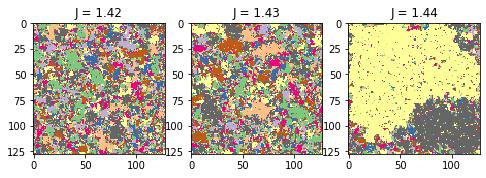

In [ ]:
dfig, axs = plt.subplots(1, len(Jvals), figsize=(8, 8))
for t in tqdm(range(len(Jvals))):
    arr = gibbs_sampler(key, Jvals[t], niter=8000)
    axs[t].imshow(arr, cmap="Accent", interpolation="nearest")
    axs[t].set_title(f"J = {Jvals[t]}")